Figure saved to: ../results/figures\fig5_bert_comparison.pdf


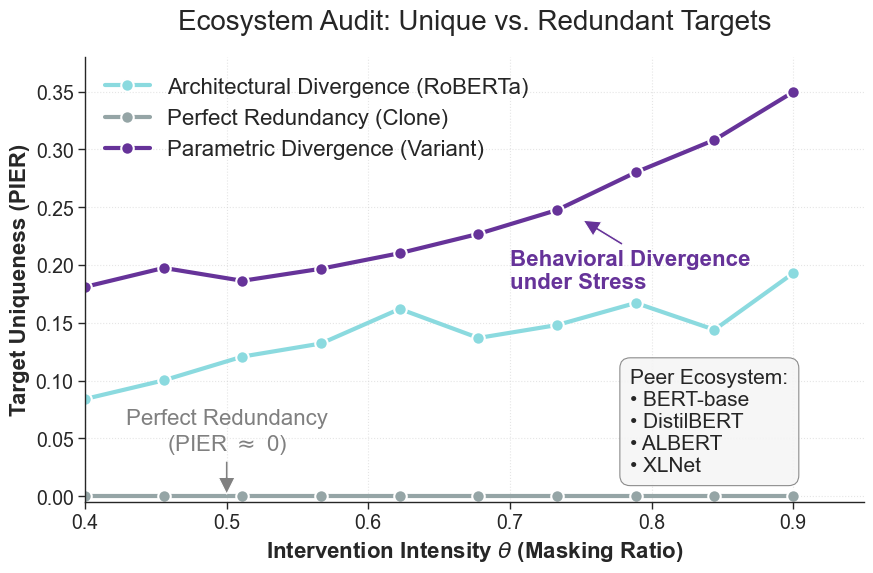

In [12]:
# notebooks/04_bert_case_study.ipynb

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Load Data
DATA_PATH = "../results/tables/exp4_bert_disco_dosesplit.csv"
FIG_PATH = "../results/figures"
os.makedirs(FIG_PATH, exist_ok=True)

df = pd.read_csv(DATA_PATH)

# 2. Aesthetics
sns.set_context("paper", font_scale=1.6)
sns.set_style("ticks")

PALETTE = {
    "Parametric Divergence (Variant)": "#663399", # Royal Purple
    "Architectural Divergence (RoBERTa)": "#8bdadf", # Asbestos Grey
    "Perfect Redundancy (Clone)": "#95a5a6", # Concrete Grey
}

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

# 3. Plot
plt.figure(figsize=(9, 6))

ax = sns.lineplot(
    data=df,
    x="Dose",
    y="PIER",
    hue="Model",
    palette=PALETTE,
    linewidth=3,
    marker="o",
    markersize=9,
    markeredgewidth=1.5,
    markeredgecolor="white"
)

# 4. Customization
ax.set_xlabel(r"Intervention Intensity $\theta$ (Masking Ratio)", fontsize=16, fontweight='bold')
ax.set_ylabel("Target Uniqueness (PIER)", fontsize=16, fontweight='bold')
ax.set_title("Ecosystem Audit: Unique vs. Redundant Targets", fontsize=20, pad=20)

# Annotations (Updated for your specific data)

# A. RoBERTa Annotation
max_pier = df[df["Model"].str.contains("RoBERTa")]["PIER"].max()
ax.annotate('Behavioral Divergence\nunder Stress', 
            xy=(0.75, 0.24), # Pointing to the high point
            xytext=(0.7, 0.18),
            arrowprops=dict(facecolor='#663399', shrink=0.05, width=2, headwidth=12),
            fontsize=16, color='#663399', fontweight='bold')

# B. Clone Annotation
ax.annotate('Perfect Redundancy\n(PIER $\\approx$ 0)', 
            xy=(0.5, 0.0), 
            xytext=(0.5, 0.04),
            arrowprops=dict(facecolor='gray', shrink=0.05, width=2, headwidth=12),
            fontsize=16, color='gray', ha='center')

sns.despine()
ax.grid(True, linestyle=':', alpha=0.5)

# X-Axis: 0 to 0.8
ax.set_xlim(0.4, 0.95)

# Y-Axis: Make sure 0 is visible, top has headroom
# RoBERTa max is ~0.14, so 0.16 is good.
ax.set_ylim(-0.005, 0.38) 

ax.legend(title="", frameon=False, fontsize=16, loc='upper left')

# C. Peer Ecosystem Info (Bottom Right)
peer_text = "Peer Ecosystem:\n• BERT-base\n• DistilBERT\n• ALBERT\n• XLNet"
ax.text(0.7, 0.06, peer_text, transform=ax.transAxes, 
        fontsize=15, va='bottom', ha='left',
        bbox=dict(boxstyle="round,pad=0.5", fc="#F5F5F5", ec="gray", alpha=0.9))

plt.tight_layout()

# Save
save_path = os.path.join(FIG_PATH, "fig5_bert_comparison.pdf")
plt.savefig(save_path, format="pdf", dpi=300, bbox_inches="tight")
print(f"Figure saved to: {save_path}")
plt.show()

Figure saved to: ../results/figures\fig5_bert_heatmap.pdf


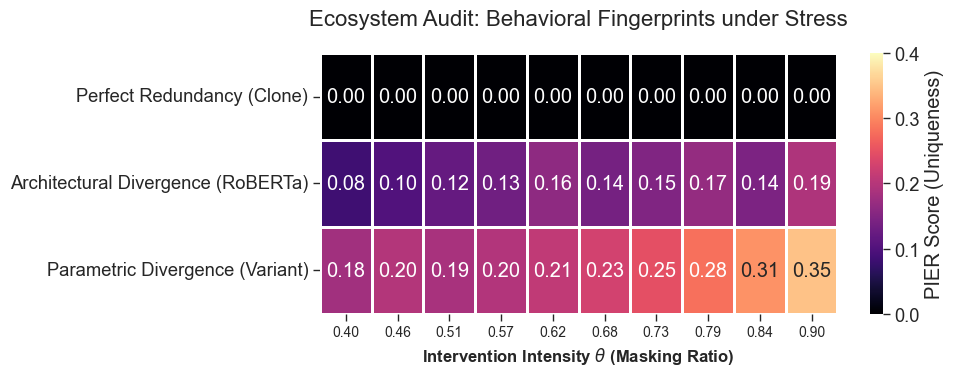

In [16]:
# notebooks/04_bert_heatmap.ipynb

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Load Data
DATA_PATH = "../results/tables/exp4_bert_disco_dosesplit.csv"
FIG_PATH = "../results/figures"
os.makedirs(FIG_PATH, exist_ok=True)

if not os.path.exists(DATA_PATH):
    print("Warning: Data file not found.")
else:
    df = pd.read_csv(DATA_PATH)

# --- Preprocessing for Heatmap ---
# We need a matrix: Rows = Models, Cols = Doses, Values = PIER
# Filter for Evaluation Phase only (Dose >= 0.4) to focus on the "Audit" part
heatmap_df = df[df['Dose'] >= 0.35].pivot(index="Model", columns="Dose", values="PIER")

# Sort rows to tell a story: Clone (Top) -> RoBERTa -> Variant (Bottom)
# Or sort by average PIER intensity
heatmap_df['mean'] = heatmap_df.mean(axis=1)
heatmap_df = heatmap_df.sort_values('mean').drop('mean', axis=1)

# Rename index for cleaner labels
name_map = {
    "DistilBERT (Redundant)": "Clone (Redundant)",
    "RoBERTa (Unique)": "RoBERTa (Unique)",
    "DistilBERT (Near-Redundant)": "Variant (Parametric)",
    "DistilBERT (Near‑Redundant)": "Variant (Parametric)"
}
heatmap_df.index = heatmap_df.index.map(lambda x: name_map.get(x, x))

# 2. Configure Aesthetics
sns.set_context("paper", font_scale=1.5)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

# 3. Plot Heatmap
plt.figure(figsize=(10, 4)) # Wide and short aspect ratio

# Draw Heatmap
# cmap="magma" gives a nice "Dark -> Bright" scientific feel
# vmin=0 ensure 0 is black/dark
ax = sns.heatmap(
    heatmap_df, 
    cmap="magma", 
    annot=True,       # Show values for precision
    fmt=".2f",        # 2 decimal places
    linewidths=1.0,   # Grid lines
    linecolor='white',
    cbar_kws={'label': 'PIER Score (Uniqueness)'},
    vmin=0.0,
    vmax=0.4          # Cap visual range to make differences pop
)

# 4. Customization
ax.set_title("Ecosystem Audit: Behavioral Fingerprints under Stress", fontsize=16, pad=20)
ax.set_xlabel(r"Intervention Intensity $\theta$ (Masking Ratio)", fontsize=12, fontweight='bold')
ax.set_ylabel("", fontsize=12)

# Rotate x-axis labels for readability, keep 2 decimal places
new_labels = [f"{col:.2f}" for col in heatmap_df.columns]
ax.set_xticklabels(new_labels, rotation=0, fontsize=10)
# plt.xticks(rotation=0)
# Ensure y-axis labels are horizontal
plt.yticks(rotation=0)

plt.tight_layout()

# Save
save_path = os.path.join(FIG_PATH, "fig5_bert_heatmap.pdf")
plt.savefig(save_path, format="pdf", dpi=300, bbox_inches="tight")
print(f"Figure saved to: {save_path}")

plt.show()